<a href="https://colab.research.google.com/github/moonlightbotanist/ColoradoView_LST/blob/master/landsat578_compare_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import common python libs

In [0]:
import os
import sys
import datetime
import math
import csv
import numpy as np                  # to create a sequence for plotting
from scipy.spatial import distance  # for Jensen-Shannon
import matplotlib.pyplot as plt     # for plotting histograms
import pandas as pd                 # for creating histogram dataframe to export to GDrive
from google.colab import drive      # for exporting from distributed machine to GDrive
from google.colab import files

install, import, & authenticate earthengine python API

In [0]:
##@title install earthengine python API

##reference: https:#developers.google.com/earth-engine/python_install_manual
#!pip install google-api-python-client
#!python -c "from oauth2client import crypt"
#!openssl version
!pip install 'pyOpenSSL>=0.11'
!pip install earthengine-api

In [0]:
##@title set up authentication credentials (earthengine)
!earthengine authenticate

# test 1: should not show any error message with the following command
#!python -c "import ee; ee.Initialize()"
# Import the Earth Engine Python Package
import ee
# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize()

# test 2: should print the metadata of the test image
# Print the information for an image asset.
image = ee.Image('srtm90_v4')
print(image.getInfo())

Mount Google Drive for exporting CSV later

In [0]:
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


--------------------------------------------------------------------------
**Beginning of GEE histogram export script**
<br>Import assets and data from GEE repository

In [0]:
# Landsat ARD assets
Landsat5 = ee.ImageCollection('projects/ColoradoView/Landsat/ARD/5')
Landsat7 = ee.ImageCollection('projects/ColoradoView/Landsat/ARD/7')
Landsat8 = ee.ImageCollection('projects/ColoradoView/Landsat/ARD/8')

# Polygons for clipping analysis
State_Bnds = ee.FeatureCollection('TIGER/2016/States')
Counties = ee.FeatureCollection('TIGER/2016/Counties')

# Get the State boundary of Colorado
CO_bnds = State_Bnds.filter(ee.Filter.eq('GEOID', '08'));
#Map.addLayer(CO_bnds,{}, 'CO_bnds')
print(CO_bnds, 'CO_bnds')

NameError: ignored

Run bitwise operators of PixelQA band to mask clouds

In [0]:
def maskARDlst(image):
  fillBitMask = 1
  clearBitMask = 1 << 1
  waterBitMask = 1 << 2
  shadowBitMask = 1 << 3
  snowBitMask = 1 << 4
  cloudBitMask = 1 << 5
  occlusionBitMask = 1 << 10
  
  lst_name = 'b1'
  pixelqa_name = 'b2'
  lstqa_name = 'b3'
  lstqa_scale_name = 'STQA_scale_factor'
  
  lstqa_threshold = 5.0;
  
  # Get the pixel QA band
  pixelqa = image.select(pixelqa_name)
  
  # Get the STQA band
  lstqa = image.select(lstqa_name)
  stqa_scale = ee.Number(image.get(lstqa_scale_name))
  
  mask = pixelqa.bitwiseAnd(fillBitMask).eq(0)\
        .And(pixelqa.bitwiseAnd(clearBitMask).neq(0))\
        .And(pixelqa.bitwiseAnd(waterBitMask).eq(0))\
        .And(pixelqa.bitwiseAnd(shadowBitMask).eq(0))\
        .And(pixelqa.bitwiseAnd(snowBitMask).eq(0))\
        .And(pixelqa.bitwiseAnd(cloudBitMask).eq(0))\
        .And(pixelqa.bitwiseAnd(occlusionBitMask).eq(0))\
        .And(lstqa.multiply(stqa_scale).lt(lstqa_threshold))          
        #.and(pixelqa.bitwiseAnd(cloudConfBit7Mask).eq(0))#.and(pixelqa.bitwiseAnd(cirrusConfBit9Mask).eq(0))
              
# Return the masked image (excluding the PIXELQA and STQA layers)
  return image.updateMask(mask).select(lst_name)

# Run the function for each sensor
L5_masked = Landsat5.map(maskARDlst)
# print(L5_masked)
L7_masked = Landsat7.map(maskARDlst)
# print(L7_masked)
L8_masked = Landsat8.map(maskARDlst)
# print(L8_masked)

Function to produce and export histograms

In [0]:
#### Need to filter by date here for the calculation of the histogram
ST_YEAR = 2000
ED_YEAR = 2002
YEAR_RANGE = ED_YEAR - ST_YEAR
startYears = [str(iYr+2000) for iYr in range(YEAR_RANGE)]
endYears = [str(iYr+2000+1) for iYr in range(YEAR_RANGE)] 

print("startYears", startYears)
print("endYears", endYears)

# Define values for histogram
minTemp = 2000
maxTemp = 3500
nBins = (maxTemp-minTemp) #.1 degree bins
print('number of bins', nBins)

# Function to produce and export histograms
def filter_and_export_histogram_sequence(ls_sensor,sensor_str):
  for i in range(0,len(startYears)):
    ls_filtered = ls_sensor.filterDate(startYears[i]+'-01-01', endYears[i]+'-01-01')
    print(ls_filtered)
    ls_img = ls_filtered.select('b1').toBands().clipToCollection(CO_bnds)
    hist = ee.FeatureCollection(ls_img.reduceRegion(reducer = ee.Reducer.fixedHistogram(minTemp, maxTemp, nBins), geometry= CO_bnds.geometry(), maxPixels=1e13))
    hist_feature = ee.Feature(None,hist)
    hist_fc = ee.FeatureCollection(hist_feature)
    print(hist_fc)
    hist_exp_task = ee.batch.Export.table.toDrive(collection = hist_fc,
                                            description = sensor_str + '_' + startYears[i] + '_' + endYears[i], 
                                            fileNamePrefix = sensor_str + '_' + startYears[i] + '_' + endYears[i],
                                            fileFormat = 'CSV')
    hist_exp_task.start()

startYears ['2000', '2001']
endYears ['2001', '2002']
number of bins 1500


Initialize L5 histogram calculation and export. Takes around four hours to run.

In [0]:
filter_and_export_histogram_sequence(L5_masked, 'L5')

Initialize L7 histogram calculation and export. Takes around six hours to run.

In [0]:
filter_and_export_histogram_sequence(L7_masked, 'L7')

Initialize L8 histogram calculation and export. Takes around three hours to run.

In [0]:
filter_and_export_histogram_sequence(L8_masked, 'L8')

In [0]:
print(l5_exp_task.status())
print(l7_exp_task.status())
# print(l8_exp_task.status())

{'id': 'FFHZMKU3QJC7IGAFFFIBAITM', 'state': 'RUNNING', 'creation_timestamp_ms': 1573254523419, 'update_timestamp_ms': 1573254732190, 'description': 'l5exportTable_2000_2009', 'task_type': 'EXPORT_FEATURES', 'start_timestamp_ms': 1573254582084, 'progress': 0.0}
{'id': 'BWDHNWVZZLSCHCPTSUX5EXF2', 'state': 'READY', 'creation_timestamp_ms': 1573254524577, 'update_timestamp_ms': 1573254524577, 'description': 'l7exportTable_2000_2009', 'task_type': 'EXPORT_FEATURES'}


--------------------------------------------------------------------------
**Load lists of CSVs for each sensor from Google Drive and convert to dictionaries**

In [0]:
# Get lists of full paths of files in directories
import pathlib

# Function to create list of files in the folder for each sensor
def get_file_list(in_dir):
  out_list = []
  for filepath in pathlib.Path(in_dir).glob('*.csv'):
    out_list.append(filepath.absolute())
  return out_list

# Run the function and print the resulting list of files | Length should be 19 if expecting all years of Landsat data
L5list = get_file_list('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5')
print("L5list", len(L5list), L5list)
L7list = get_file_list('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L7')
print("L7list", len(L7list), L7list)
L8list = get_file_list('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L8')
print("L8list", len(L8list), L8list)

# Load CSVs as list of Pandas dataframes with keys for each image corresponding to the histograms
def load_csvs_to_list_pd_dfs(in_file_list):
  pdList = []
  for iFile in range(len(in_file_list)):
    pdList.append(pd.read_csv(in_file_list[iFile]))
  return pdList

# Run the function for each sensor's list of files
L5pds = load_csvs_to_list_pd_dfs(L5list)
L7pds = load_csvs_to_list_pd_dfs(L7list)
L8pds = load_csvs_to_list_pd_dfs(L8list)

# Create empty lists to contain dictionaries once converted
L5dicts = []
L7dicts = []
L8dicts = []

# For loop to convert each Pandas dataframe into a dictionary for merging
for ipd in range(len(L5pds)):
  L5dicts.append(L5pds[ipd].to_dict())
for ipd in range(len(L7pds)):
  L7dicts.append(L7pds[ipd].to_dict())
for ipd in range(len(L8pds)):
  L8dicts.append(L8pds[ipd].to_dict())

L5list 19 [PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2004_2005.csv'), PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2003_2004.csv'), PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2005_2006.csv'), PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2006_2007.csv'), PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2007_2008.csv'), PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2008_2009.csv'), PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2009_2010.csv'), PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2010_2011.csv'), PosixPath('/content/gdrive/My Drive/ARD_LST_CO/JensenShannonCalculations/Histograms/L5/L5_2012_2013.csv'), PosixPath('/content/gdrive

Merge the dictionaries into single dictionary for each sensor

In [0]:
# Create empty dictionaries to merge the individual dictionsaries into
colHist5_cli = {}
colHist7_cli = {}
colHist8_cli = {}

# Merge list of dictionaries into a single dictionary for each sensor
for d in L5dicts:
  colHist5_cli.update(d)
for d in L7dicts:
  colHist7_cli.update(d)
for d in L8dicts:
  colHist8_cli.update(d)

# Confirm type and length of each sensor dictionary
print(type(colHist5_cli), len(colHist5_cli))
print(type(colHist7_cli), len(colHist7_cli))
print(type(colHist8_cli), len(colHist8_cli))

<class 'dict'> 11460
<class 'dict'> 18669
<class 'dict'> 4654


**Note: In the section below there are scripts for producing lists of histograms by year and also for producing lists of histograms by month for each sensor.**

-----------------------------------------------------------------------------
**Produce list of dictionaries for *each YEAR* by running the following functions**<BR>
**First:** Get dictionary key list for each sensor

In [0]:
# Function to produce lists of keys for each sensor
def getYearKeyList(yearly_dict): 
    full_list = [] 
    for key in yearly_dict.keys(): 
        full_list.append(key)      
    return full_list

l5keys_yr = getYearKeyList(colHist5_cli)
l7keys_yr = getYearKeyList(colHist7_cli)
l8keys_yr = getYearKeyList(colHist8_cli)

**Second:** Produce a list of list of filter keys for each sensor for each year<BR>
*Change the yearList variable between compPeriod57 and compPeriod78 for assessing each of the two sets of sensors. The scripts below this are written for assessing one of these two periods at a time.*

In [0]:
# Comparable periods for Landsat 5 and 7 and for Landsat 7 and 8
# 2007 currently excluded because of issues with Landsat 7 data for that year
compPeriod57 = [2000,2001,2002,2003,2004,2005,2006,2008,2009,2010,2011]
compPeriod78 = list(range(2014,2019))
allYears = list(range(2014,2019))

# Filter by period of interest
yearList = compPeriod78 #substitute in either compPeriod57 or compPeriod78 depending on period of interest
print(yearList)

# Function to produce a list of lists of keys (image tiles) for each year in yearList
# Can index the year of the key by [15:19] index of string
def filter_year(keys_list, sensor_list):
  for iYr in range(0,len(yearList)):
    for iKey in range(1,len(keys_list)):
      # filter keys that are not from images, such as system keys
      if keys_list[iKey][0] == 'L':
        year = int(keys_list[iKey][15:19])
        if year == yearList[iYr]:
          # Create list to add to list of lists
          annual_list = []
          annual_list.append(keys_list[iKey])
          sensor_list[iYr].append(tuple(annual_list))
  return sensor_list

[2014, 2015, 2016, 2017, 2018]


In [0]:
# Run filter_year function for L5 and L7
L5_filt_list_yr = [[]for i in range(len(compPeriod57))]
L5_filt_keys_yr = filter_year(l5keys_yr, L5_filt_list_yr)
L7_filt_list_yr = [[]for i in range(len(compPeriod57))]
L7_filt_keys_yr = filter_year(l7keys_yr, L7_filt_list_yr)

In [0]:
# Run filter_year function for L7 and L8
L7_filt_list_yr = [[]for i in range(len(compPeriod78))]
L7_filt_keys_yr = filter_year(l7keys_yr, L7_filt_list_yr)
L8_filt_list_yr = [[]for i in range(len(compPeriod78))]
L8_filt_keys_yr = filter_year(l8keys_yr, L8_filt_list_yr)

**Third:** Produce lists of dictionaries for each year for each sensor

In [0]:
# Function to produce lists of dictionaries by year
def yearly_lists_of_dicts(sensor_keys, sensor_dict):
  FullList = []
  for iYr in range(0,len(yearList)):
    YearDict = {}
    YearClean = {}
    for iKey in range(0,len(sensor_keys[iYr])):
      key = str(sensor_keys[iYr][iKey])
      #print(str(key), type(key))
      YearDict[key[2:53]] = {k: sensor_dict[k] for k in sensor_keys[iYr][iKey] if k in sensor_dict}
      YearClean[key[2:53]] = list(YearDict[key[2:53]].values())[0]
    FullList.append(YearClean)
  return FullList

In [0]:
# Run yearly_lists_of_dicts function for L5 and L7
L5_yearly_dicts = yearly_lists_of_dicts(L5_filt_keys_yr, colHist5_cli)
L7_yearly_dicts = yearly_lists_of_dicts(L7_filt_keys_yr, colHist7_cli)

# #Print functions to assess outputs
yearPrint = 4
print(type(L5_yearly_dicts), len(L5_yearly_dicts))
print(type(L5_yearly_dicts[yearPrint]), len(L5_yearly_dicts[yearPrint]))
print(L5_yearly_dicts[yearPrint].keys())

<class 'list'> 11
<class 'dict'> 1035
dict_keys(['LT05_CU_009008_20040110_20181230_C01_V01_stacked_b1', 'LT05_CU_009008_20040117_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040126_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040202_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040211_20181230_C01_V01_stacked_b1', 'LT05_CU_009008_20040225_20181229_C01_V01_stacked_b1', 'LT05_CU_009008_20040305_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040312_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040314_20181229_C01_V01_stacked_b1', 'LT05_CU_009008_20040321_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040328_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040330_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040406_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040413_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040415_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040501_20190515_C01_V01_stacked_b1', 'LT05_CU_009008_20040508_20190108_C01_V01_stacked_b1', 'LT05_CU_009008_

In [0]:
# Run yearly_lists_of_dicts function for L7 and L8
L7_yearly_dicts = yearly_lists_of_dicts(L7_filt_keys_yr, colHist7_cli)
L8_yearly_dicts = yearly_lists_of_dicts(L8_filt_keys_yr, colHist8_cli)

#Print functions to assess outputs
yearPrint = 0
print(type(L7_yearly_dicts), len(L7_yearly_dicts))
print(type(L7_yearly_dicts[yearPrint]), len(L7_yearly_dicts[yearPrint]))
print(L7_yearly_dicts[yearPrint].keys())

<class 'list'> 5
<class 'dict'> 1082
dict_keys(['LE07_CU_009008_20140104_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140113_20181208_C01_V01_stacked_b1', 'LE07_CU_009008_20140120_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140221_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140228_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140302_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140309_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140316_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140325_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140403_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140410_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140417_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140419_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140503_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140505_20190208_C01_V01_stacked_b1', 'LE07_CU_009008_20140512_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140519_20181208_C01_V01_stacked_b1', 'LE07_CU_009008_2

------------------------------------------------------------------------
**Produce list of dictionaries for *each MONTH* by running the following functions**<BR>
**First:** Get list of keys for each sensor

In [0]:
# Function to produce lists of keys for each sensor
def getMonthKeyList(monthly_dict): 
    full_list = [] 
    for key in monthly_dict.keys(): 
        full_list.append(key)      
    return full_list

l5keys_mo = getMonthKeyList(colHist5_cli)
l7keys_mo = getMonthKeyList(colHist7_cli)
l8keys_mo = getMonthKeyList(colHist8_cli)

**Second:** Filter by the period of interest for either L5 and L7 or L7 and L8 <BR>
*Change the yearList variable between compPeriod57 and compPeriod78 for assessing each of the two sets of sensors. The scripts below this are written for assessing one of these two periods at a time.* 

In [0]:
# Comparable periods for Landsat 5 and 7 and for Landsat 7 and 8
# 2007 currently excluded because of issues with Landsat 7 data for that year
compPeriod57 = [2000,2001,2002,2003,2004,2005,2006,2008,2009,2010,2011]
compPeriod78 = list(range(2014,2019))

# Filter by period of interest
yearList = compPeriod78 #insert either compPeriod57 or compPeriod78 here

# Function to produce list of keys within the specified filterYear
# Can index the year of the key by [15:19] index of string
def filter_sensor_comp(month_keys_list):
  clean_month_list = []
  for iKey in range(1,len(month_keys_list)):
    # filter keys that are not from images, such as system keys
    if month_keys_list[iKey][0] == 'L':
      year = int(month_keys_list[iKey][15:19])
      if year in yearList:
        clean_month_list.append(month_keys_list[iKey])
  return clean_month_list

In [0]:
# Filter dictionary keys for period of Landsat 5 and 7
l5_filt_keys_mo = filter_sensor_comp(l5keys_mo)
print(len(l5_filt_keys_mo))
print(type(l5_filt_keys_mo))
print(l5_filt_keys_mo)

l7_filt_keys_mo = filter_sensor_comp(l7keys_mo)
print(len(l7_filt_keys_mo))
print(type(l7_filt_keys_mo))
print(l7_filt_keys_mo)

10652
<class 'list'>
['LT05_CU_009008_20040110_20181230_C01_V01_stacked_b1', 'LT05_CU_009008_20040117_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040126_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040202_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040211_20181230_C01_V01_stacked_b1', 'LT05_CU_009008_20040225_20181229_C01_V01_stacked_b1', 'LT05_CU_009008_20040305_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040312_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040314_20181229_C01_V01_stacked_b1', 'LT05_CU_009008_20040321_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040328_20190109_C01_V01_stacked_b1', 'LT05_CU_009008_20040330_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040406_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040413_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040415_20190105_C01_V01_stacked_b1', 'LT05_CU_009008_20040501_20190515_C01_V01_stacked_b1', 'LT05_CU_009008_20040508_20190108_C01_V01_stacked_b1', 'LT05_CU_009008_20040515_20190104_C01_V01_s

In [0]:
# Filter dictionary keys for period of Landsat 5 and 7
l7_filt_keys_mo = filter_sensor_comp(l7keys_mo)
print(len(l7_filt_keys_mo))
print(type(l7_filt_keys_mo))
print(l7_filt_keys_mo)

l8_filt_keys_mo = filter_sensor_comp(l8keys_mo)
print(len(l8_filt_keys_mo))
print(type(l8_filt_keys_mo))
print(l8_filt_keys_mo)

5276
<class 'list'>
['LE07_CU_009008_20140104_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140113_20181208_C01_V01_stacked_b1', 'LE07_CU_009008_20140120_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140221_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140228_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140302_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140309_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140316_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140325_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140403_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140410_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140417_20190505_C01_V01_stacked_b1', 'LE07_CU_009008_20140419_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140503_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140505_20190208_C01_V01_stacked_b1', 'LE07_CU_009008_20140512_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140519_20181208_C01_V01_stacked_b1', 'LE07_CU_009008_20140521_20190504_C01_V01_st

**Third:** Produce a list of list of filter keys for each sensor for each month<BR>

In [0]:
# Filter by monthList
monthList = ['01','02','03','04','05','06','07','08','09','10','11','12']
print(monthList)
print(len(monthList))
print(range(0,len(monthList)))

# Function to produce a list of lists of keys (image tiles) for each year in yearList
# Can index the year of the key by [15:19] index of string
def filter_month(keys_list, sensor_list):
  for iMo in range(0,len(monthList)):
    for iKey in range(0,len(keys_list)):
      # filter keys that are not from images, such as system keys
      if keys_list[iKey][0] == 'L':
        month = keys_list[iKey][19:21]
        if month == monthList[iMo]:
          # Create list to add to list of lists
          month_list = []
          month_list.append(keys_list[iKey])
          sensor_list[iMo].append(tuple(month_list))
  return sensor_list

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
12
range(0, 12)


In [0]:
# Run filter_month function for L5 and L7
L5_filt_list = [[]for i in range(len(monthList))]
L5_month_keys = filter_month(l5_filt_keys_mo, L5_filt_list)
print(len(L5_month_keys))
print(L5_month_keys[6])
print(len(L5_month_keys[6]))

L7_filt_list = [[]for i in range(len(monthList))]
L7_month_keys = filter_month(l7_filt_keys_mo, L7_filt_list)
print(len(L7_month_keys))
print(L7_month_keys[6])
print(len(L7_month_keys[6]))

12
[('LT05_CU_009008_20040704_20190104_C01_V01_stacked_b1',), ('LT05_CU_009008_20040711_20190104_C01_V01_stacked_b1',), ('LT05_CU_009008_20040718_20181228_C01_V01_stacked_b1',), ('LT05_CU_009008_20040720_20190104_C01_V01_stacked_b1',), ('LT05_CU_009008_20040727_20190108_C01_V01_stacked_b1',), ('LT05_CU_009009_20040704_20190108_C01_V01_stacked_b1',), ('LT05_CU_009009_20040711_20190104_C01_V01_stacked_b1',), ('LT05_CU_009009_20040713_20190104_C01_V01_stacked_b1',), ('LT05_CU_009009_20040720_20190108_C01_V01_stacked_b1',), ('LT05_CU_009009_20040727_20190108_C01_V01_stacked_b1',), ('LT05_CU_009009_20040729_20190108_C01_V01_stacked_b1',), ('LT05_CU_009010_20040704_20190108_C01_V01_stacked_b1',), ('LT05_CU_009010_20040711_20190104_C01_V01_stacked_b1',), ('LT05_CU_009010_20040713_20190104_C01_V01_stacked_b1',), ('LT05_CU_009010_20040720_20190108_C01_V01_stacked_b1',), ('LT05_CU_009010_20040729_20190108_C01_V01_stacked_b1',), ('LT05_CU_009011_20040704_20190104_C01_V01_stacked_b1',), ('LT05_CU_

In [0]:
# Run filter_month function for L7 and L8
L7_filt_list = [[]for i in range(len(monthList))]
L7_month_keys = filter_month(l7_filt_keys_mo, L7_filt_list)
print(len(L7_month_keys))
print(L7_month_keys[7])
print(len(L7_month_keys[7]))

L8_filt_list = [[]for i in range(len(monthList))]
L8_month_keys = filter_month(l8_filt_keys_mo, L8_filt_list)
print(len(L8_month_keys))
print(L8_month_keys[7])
print(len(L8_month_keys[7]))

12
[('LE07_CU_009008_20140807_20190504_C01_V01_stacked_b1',), ('LE07_CU_009008_20140809_20190504_C01_V01_stacked_b1',), ('LE07_CU_009008_20140816_20190504_C01_V01_stacked_b1',), ('LE07_CU_009008_20140823_20190208_C01_V01_stacked_b1',), ('LE07_CU_009008_20140825_20190503_C01_V01_stacked_b1',), ('LE07_CU_009009_20140802_20190504_C01_V01_stacked_b1',), ('LE07_CU_009009_20140809_20190504_C01_V01_stacked_b1',), ('LE07_CU_009009_20140816_20190504_C01_V01_stacked_b1',), ('LE07_CU_009009_20140818_20190504_C01_V01_stacked_b1',), ('LE07_CU_009009_20140825_20190503_C01_V01_stacked_b1',), ('LE07_CU_009010_20140802_20190504_C01_V01_stacked_b1',), ('LE07_CU_009010_20140809_20190504_C01_V01_stacked_b1',), ('LE07_CU_009010_20140816_20190504_C01_V01_stacked_b1',), ('LE07_CU_009010_20140818_20190504_C01_V01_stacked_b1',), ('LE07_CU_009010_20140825_20190503_C01_V01_stacked_b1',), ('LE07_CU_009011_20140802_20190504_C01_V01_stacked_b1',), ('LE07_CU_009011_20140809_20190504_C01_V01_stacked_b1',), ('LE07_CU_

**Fourth:** Produce lists of dictionaries for each month for each sensor

In [0]:
# Function to produce lists of dictionaries by year
def monthly_lists_of_dicts(sensor_filt_keys, sensor_dict):
  FullList = []
  for iMo in range(0,len(monthList)):
    MonthDict = {}
    MonthClean = {}
    for iKey in range(0,len(sensor_filt_keys[iMo])):
      key = str(sensor_filt_keys[iMo][iKey])
      MonthDict[key[2:53]] = {k: sensor_dict[k] for k in sensor_filt_keys[iMo][iKey] if k in sensor_dict}
      MonthClean[key[2:53]] = list(MonthDict[key[2:53]].values())[0]
    FullList.append(MonthClean)
  return FullList

In [0]:
# Run monthly_lists_of_dicts function for L5 and L7
L5_monthly_dicts = monthly_lists_of_dicts(L5_month_keys, colHist5_cli)
L7_monthly_dicts = monthly_lists_of_dicts(L7_month_keys, colHist7_cli)

#Print functions to assess outputs
monthPrint = 7
print(type(L5_monthly_dicts), len(L5_monthly_dicts))
print(type(L5_monthly_dicts[monthPrint]), len(L5_monthly_dicts[monthPrint]))
print(L5_monthly_dicts[monthPrint].keys())
print(L5_monthly_dicts[monthPrint].get('LT05_CU_010009_20030805_20190109_C01_V01_stacked_b1'))

<class 'list'> 12
<class 'dict'> 1075
dict_keys(['LT05_CU_009008_20040803_20190104_C01_V01_stacked_b1', 'LT05_CU_009008_20040805_20190104_C01_V01_stacked_b1', 'LT05_CU_009008_20040812_20190108_C01_V01_stacked_b1', 'LT05_CU_009008_20040819_20190104_C01_V01_stacked_b1', 'LT05_CU_009008_20040821_20190104_C01_V01_stacked_b1', 'LT05_CU_009008_20040828_20190108_C01_V01_stacked_b1', 'LT05_CU_009009_20040812_20181228_C01_V01_stacked_b1', 'LT05_CU_009009_20040814_20190104_C01_V01_stacked_b1', 'LT05_CU_009009_20040821_20190108_C01_V01_stacked_b1', 'LT05_CU_009009_20040828_20190108_C01_V01_stacked_b1', 'LT05_CU_009009_20040830_20190104_C01_V01_stacked_b1', 'LT05_CU_009010_20040805_20190104_C01_V01_stacked_b1', 'LT05_CU_009010_20040812_20190108_C01_V01_stacked_b1', 'LT05_CU_009010_20040814_20190104_C01_V01_stacked_b1', 'LT05_CU_009010_20040821_20190108_C01_V01_stacked_b1', 'LT05_CU_009010_20040828_20190108_C01_V01_stacked_b1', 'LT05_CU_009010_20040830_20190104_C01_V01_stacked_b1', 'LT05_CU_009011_

In [0]:
# Run monthly_lists_of_dicts function for L7 and L8
L7_monthly_dicts = monthly_lists_of_dicts(L7_month_keys, colHist7_cli)
L8_monthly_dicts = monthly_lists_of_dicts(L8_month_keys, colHist8_cli)

#Print functions to assess outputs
monthPrint = 7
print(type(L7_monthly_dicts), len(L7_monthly_dicts))
print(type(L7_monthly_dicts[monthPrint]), len(L7_monthly_dicts[monthPrint]))
print(L7_monthly_dicts[monthPrint].keys())
print(L7_monthly_dicts[monthPrint].get('LE07_CU_009011_20170826_20181203_C01_V01_stacked_b1'))

<class 'list'> 12
<class 'dict'> 514
dict_keys(['LE07_CU_009008_20140807_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140809_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140816_20190504_C01_V01_stacked_b1', 'LE07_CU_009008_20140823_20190208_C01_V01_stacked_b1', 'LE07_CU_009008_20140825_20190503_C01_V01_stacked_b1', 'LE07_CU_009009_20140802_20190504_C01_V01_stacked_b1', 'LE07_CU_009009_20140809_20190504_C01_V01_stacked_b1', 'LE07_CU_009009_20140816_20190504_C01_V01_stacked_b1', 'LE07_CU_009009_20140818_20190504_C01_V01_stacked_b1', 'LE07_CU_009009_20140825_20190503_C01_V01_stacked_b1', 'LE07_CU_009010_20140802_20190504_C01_V01_stacked_b1', 'LE07_CU_009010_20140809_20190504_C01_V01_stacked_b1', 'LE07_CU_009010_20140816_20190504_C01_V01_stacked_b1', 'LE07_CU_009010_20140818_20190504_C01_V01_stacked_b1', 'LE07_CU_009010_20140825_20190503_C01_V01_stacked_b1', 'LE07_CU_009011_20140802_20190504_C01_V01_stacked_b1', 'LE07_CU_009011_20140809_20190504_C01_V01_stacked_b1', 'LE07_CU_009011_2

Note: There is no comparable period for Landsat 5 and 8 since their data collection lifespans did not overlap.

-----------------------------------------------------------------------------
**Create clean lists of np.arrays for each sensor (*Required*)**<BR>
(*Everything below is required to generate the desired histogram*)


In [0]:
# Function to convert the strings into a list
def convert_str_list_to_float_list(in_str_list):
  ## ['0.0', '1.0'] -> [0.0, 1.0]
  return [float(iStr) for iStr in in_str_list]

In [0]:
# Create lists of np.arrays for each sensor
# This function parses the strings contained into clean arrays for each dictionary key.
def parse_list_convert_np_array(in_LS_dicts):
  NP_list = [[]for i in range(len(in_LS_dicts))]
  for i in range(len(in_LS_dicts)):
    LSkeys = list(in_LS_dicts[i].keys())
    for iKey in range(len(in_LS_dicts[i])):
      if isinstance(in_LS_dicts[i][LSkeys[iKey]][0], str) == True:
        TBParseStr = in_LS_dicts[i][LSkeys[iKey]][0]
        ParseList1 = TBParseStr.split('], [')
        ParseList2 = [ (iStr[1:] if (iStr[0] == '[') else iStr[:-1]) for iStr in ParseList1]
        ParseList3 = [ (iStr[1:] if (iStr[0] == '[') else iStr[:-1]) for iStr in ParseList2]
        ParseList4 = [ convert_str_list_to_float_list(iStr.split(', ')) for iStr in ParseList3]
        ParseNP = np.array(ParseList4)
        NP_list[i].append(ParseNP)
  return(NP_list)

Lists of arrays for each year for each sensor

In [0]:
NPclean5 = parse_list_convert_np_array(L5_yearly_dicts)

print(len(NPclean5))
print(len(NPclean5[0]))

11
747


In [0]:
NPclean7 = parse_list_convert_np_array(L7_yearly_dicts)

print(len(NPclean7))
print(len(NPclean7[0]))

5
938


In [0]:
NPclean8 = parse_list_convert_np_array(L8_yearly_dicts)

print(len(NPclean8))
print(len(NPclean8[0]))

5
687


Lists of arrays for each month for each sensor

In [0]:
NPclean5 = parse_list_convert_np_array(L5_monthly_dicts)

print(len(NPclean5))
print(len(NPclean5[0]))

12
618


In [0]:
NPclean7 = parse_list_convert_np_array(L7_monthly_dicts)

print(len(NPclean7))
print(len(NPclean7[0]))

In [0]:
NPclean8 = parse_list_convert_np_array(L8_monthly_dicts)

print(len(NPclean8))
print(len(NPclean8[0]))

12
296


Produce a single item list with all of the arrays and run the function for each sensor

In [0]:
# Function vertically stacks all of the arrays in the lists of years in a single array
def vstack_arr(in_list_arr):
  list_items = []
  for i in range(len(in_list_arr)):
    list_items.append(in_list_arr[i])
  overall_arr = np.vstack(list_items)
  return(overall_arr)

#NPclean5_overall = [vstack_arr(NPclean5)]
NPclean7_overall = [vstack_arr(NPclean7)]
NPclean8_overall = [vstack_arr(NPclean8)]

#print(len(NPclean5_overall))
print(len(NPclean7_overall))
print(len(NPclean8_overall))
#print(len(NPclean5_overall[0]))
print(len(NPclean7_overall[0]))
print(len(NPclean8_overall[0]))

1
1
4578
4022


--------------------------------------------------------------------------
**Sum across all of the arrays for each sensor and then standardize the distributions**

In [0]:
# Sum across all of the arrays
# suppress scientific notation in print statements
np.set_printoptions(suppress=True)

# Function to sum across all histograms and then standardize the distribution by dividing each bin by the number of total pixels
def standardize_hist(in_np_hist):
  std_hist_list = [[]for i in range(len(in_np_hist))]
  for i in range(len(in_np_hist)):
    arr_hist = np.array(in_np_hist[i])
    arr_sum = arr_hist.sum(axis = 0)
    arr_sum[:,0] = arr_sum[:,0] / len(in_np_hist[i])*.1
    pix_sum = np.sum(arr_sum,axis=0)
    arr_sum_standardized = arr_sum
    arr_sum_standardized[:,1] = arr_sum_standardized[:,1] / pix_sum[1]
    std_hist_list[i].append(arr_sum_standardized)
  return(std_hist_list)

In [0]:
print(len(NPclean5))
print(len(NPclean5[0]))
print(len(NPclean5_overall))
print(len(NPclean5_overall[0]))

# Run the standardize function for L5 for the list of arrays by month or year and for the overall array
L5_test_pdf = standardize_hist(NPclean5)
print(L5_test_pdf[0])
L5_test_pdf_overall = standardize_hist(NPclean5_overall)
print(L5_test_pdf_overall[0])

In [0]:
print(len(NPclean7))
print(len(NPclean7[0]))
print(len(NPclean7_overall))
print(len(NPclean7_overall[0]))

# Run the standardize function for L7 for the list of arrays by month or year and for the overall array
L7_test_pdf = standardize_hist(NPclean7)
print(L7_test_pdf[0])
L7_test_pdf_overall = standardize_hist(NPclean7_overall)
print(L7_test_pdf_overall[0])

5
938
1
4578
[array([[200. ,   0. ],
       [200.1,   0. ],
       [200.2,   0. ],
       ...,
       [349.7,   0. ],
       [349.8,   0. ],
       [349.9,   0. ]])]
[array([[200. ,   0. ],
       [200.1,   0. ],
       [200.2,   0. ],
       ...,
       [349.7,   0. ],
       [349.8,   0. ],
       [349.9,   0. ]])]


In [0]:
print(len(NPclean8))
print(len(NPclean8[0]))
print(len(NPclean8_overall))
print(len(NPclean8_overall[0]))

# Run the standardize function for L8 for the list of arrays by month or year and for the overall array
L8_test_pdf = standardize_hist(NPclean8)
print(L8_test_pdf[0])
L8_test_pdf_overall = standardize_hist(NPclean8_overall)
print(L8_test_pdf_overall[0])

5
687
1
4022
[array([[200. ,   0. ],
       [200.1,   0. ],
       [200.2,   0. ],
       ...,
       [349.7,   0. ],
       [349.8,   0. ],
       [349.9,   0. ]])]
[array([[200. ,   0. ],
       [200.1,   0. ],
       [200.2,   0. ],
       ...,
       [349.7,   0. ],
       [349.8,   0. ],
       [349.9,   0. ]])]


**Function to produce lists of x values (index of degrees K) and y values (probability distributions)**

In [0]:
# Indexing nested lists must be done with recursive indexing, hence the lists below for the x and y values
def lists_of_xs(in_std_hist):
  x_list = []
  for inner_l in in_std_hist:
    for item in inner_l:
      x_list.append(item[:,0])
  return(x_list)

def lists_of_ys(in_std_hist):
  y_list = []
  for inner_l in in_std_hist:
    for item in inner_l:
      y_list.append(item[:,1])
  return(y_list)

In [0]:
# Run the function to produce lists of y values for both the yearly or monthly lists and for the overall probability distribution for L5
L5_ys = lists_of_ys(L5_test_pdf)
print(len(L5_ys))
print(L5_ys)

L5_ys_overall = lists_of_ys(L5_test_pdf_overall)
print(len(L5_ys_overall))
print(L5_ys_overall)

L5_xs = lists_of_xs(L5_test_pdf)
print(len(L5_xs))
print(L5_xs)

In [0]:
# Run the function to produce lists of y values for both the yearly or monthly lists and for the overall probability distribution for L7
L7_ys = lists_of_ys(L7_test_pdf)
print(len(L7_ys))
print(L7_ys)

L7_ys_overall = lists_of_ys(L7_test_pdf_overall)
print(len(L7_ys_overall))
print(L7_ys_overall)

5
[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
1
[array([0., 0., 0., ..., 0., 0., 0.])]


In [0]:
# Run the function to produce lists of y values for both the yearly or monthly lists and for the overall probability distribution for L8
L8_ys = lists_of_ys(L8_test_pdf)
print(len(L8_ys))
print(L8_ys)

L8_ys_overall = lists_of_ys(L8_test_pdf_overall)
print(len(L8_ys_overall))
print(L8_ys_overall)

5
[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
1
[array([0., 0., 0., ..., 0., 0., 0.])]


**Binning the histograms—1 degree and .5 degrees K**

In [0]:
# Use reshape to create inner arrays for each bin for .5 degrees and 1 degree and sum those bins to create new distribution arrays for each input list
def bin_pt5(in_np_arr):
  bin_list = []
  for i in range(len(in_np_arr)):
    bin_list.append(np.reshape(in_np_arr[i],(300,5)).sum(-1))
  return(bin_list)

def bin_1(in_np_arr):
  bin_list = []
  for i in range(len(in_np_arr)):
    bin_list.append(np.reshape(in_np_arr[i],(150,10)).sum(-1))
  return(bin_list)

In [0]:
# Apply bin functions to Landsat 5 data (yearly and monthly)
L5_ys_bin_pt5 = bin_pt5(L5_ys)
L5_ys_bin_1 = bin_1(L5_ys)

print(len(L5_ys_bin_pt5))
print(L5_ys_bin_pt5[0])
print("sum = ", L5_ys_bin_pt5[0].sum(-1))

In [0]:
# Apply bin functions to Landsat 5 data (Overall)
L5_ys_bin_pt5_overall = bin_pt5(L5_ys_overall)
L5_ys_bin_1_overall = bin_1(L5_ys_overall)

print(len(L5_ys_bin_1_overall))
print(L5_ys_bin_1_overall[0])
print("sum = ", L5_ys_bin_pt5_overall[0].sum(-1))

In [0]:
# Apply bin functions to Landsat 7 data (yearly and monthly)
L7_ys_bin_pt5 = bin_pt5(L7_ys)
L7_ys_bin_1 = bin_1(L7_ys)

print(len(L7_ys_bin_pt5))
print("sum = ", L7_ys_bin_pt5[0].sum(-1))
print(L7_ys_bin_pt5[0])

In [0]:
# Apply bin functions to Landsat 7 data (Overall)
L7_ys_bin_pt5_overall = bin_pt5(L7_ys_overall)
L7_ys_bin_1_overall = bin_1(L7_ys_overall)

print(len(L7_ys_bin_pt5_overall))
print(L7_ys_bin_1_overall[0])
print("sum = ", L7_ys_bin_pt5_overall[0].sum(-1))

1
[0.         0.         0.         0.         0.         0.
 0.         0.00000001 0.00000004 0.00000017 0.00000023 0.00000028
 0.00000041 0.00000049 0.00000061 0.00000069 0.00000097 0.000001
 0.00000142 0.00000176 0.00000271 0.00000319 0.00000356 0.00000434
 0.00000466 0.00000553 0.00000632 0.00000749 0.0000087  0.00000925
 0.0000104  0.00001066 0.00001115 0.00001195 0.00001165 0.0000136
 0.00001357 0.00001347 0.00001473 0.00001472 0.0000148  0.00002122
 0.00003335 0.00004541 0.00005668 0.00006286 0.00006831 0.00007188
 0.00007548 0.00007802 0.0000819  0.00008611 0.00008811 0.00008761
 0.0000873  0.00008931 0.00011313 0.00015404 0.00014964 0.00017494
 0.0002599  0.00018794 0.00026166 0.00040285 0.00036518 0.00061986
 0.00052521 0.00091876 0.00094196 0.00131998 0.00164281 0.00220657
 0.0027364  0.00373015 0.00486403 0.00607402 0.00711504 0.00863208
 0.0095953  0.01068039 0.01298394 0.01413079 0.01473166 0.01684424
 0.0176981  0.01735505 0.01829308 0.01870106 0.01854274 0.01931244
 0.0

In [0]:
# Apply bin functions to Landsat 8 data (yearly and monthly)
L8_ys_bin_pt5 = bin_pt5(L8_ys)
L8_ys_bin_1 = bin_1(L8_ys)

print(len(L8_ys_bin_pt5))
print(L8_ys_bin_pt5[0])
print("sum = ", L8_ys_bin_pt5[0].sum(-1))

In [0]:
# Apply bin functions to Landsat 8 data (Overall)
L8_ys_bin_pt5_overall = bin_pt5(L8_ys_overall)
L8_ys_bin_1_overall = bin_1(L8_ys_overall)

print(len(L8_ys_bin_1_overall))
print(L8_ys_bin_1_overall[0])
print("sum = ", L8_ys_bin_pt5_overall[0].sum(-1))

1
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00000001 0.00000001 0.00000005 0.00000014
 0.00000043 0.00000283 0.00000783 0.00001183 0.00001549 0.00001895
 0.00002027 0.0000217  0.0000259  0.00003343 0.00005102 0.00007954
 0.00011168 0.00013967 0.00016335 0.0001975  0.00024826 0.00030237
 0.00037466 0.0004784  0.00059751 0.00072808 0.00090855 0.00123179
 0.00176562 0.00249695 0.00353516 0.00493574 0.00641822 0.00827637
 0.01039116 0.01235634 0.01386975 0.01464679 0.01518389 0.01584635
 0.01661121 0.01764523 0.01833716 0.0188156  0.01931785 0.01979066
 0.02010417 0.02032505 0.02053707 0.02133832 0.02

**Compute Jensen-Shannon divergence**

In [0]:
# Function to compute Jensen-Shannon divergence for lists of probability distributions
def compute_js(pdf_list_1, pdf_list_2):
  js_list = [[]for i in range(len(pdf_list_1))]
  for i in range(len(pdf_list_1)):
    js = distance.jensenshannon(pdf_list_1[i],pdf_list_2[i])
    js_list[i].append(js)
  return(js_list)

In [0]:
# Compute Jensen-Shannon value for overall probability distributions for Landsat 5 and 7
js_57 = compute_js(L5_ys_overall, L7_ys_overall)
js_57_bin_pt5 = compute_js(L5_ys_bin_pt5_overall,L7_ys_bin_pt5_overall)
js_57_bin_1 = compute_js(L5_ys_bin_1_overall,L7_ys_bin_1_overall)
print(js_57)
print(js_57_bin_pt5)
print(js_57_bin_1)

[[0.047691155641232566]]
[[0.039256619703924654]]
[[0.03826408764122698]]


In [0]:
# Compute Jensen-Shannon value for overall probability distributions for Landsat 7 and 8
js_78 = compute_js(L7_ys_overall,L8_ys_overall)
js_78_bin_pt5 = compute_js(L7_ys_bin_pt5_overall,L8_ys_bin_pt5_overall)
js_78_bin_1 = compute_js(L7_ys_bin_1_overall,L8_ys_bin_1_overall)
print(js_78)
print(js_78_bin_pt5)
print(js_78_bin_1)

[[0.04190420726604753]]
[[0.0388369460884019]]
[[0.03831213828419528]]


In [0]:
# Compute lists of Jensen-Shannon values for monthly or yearly lists of probability distributions for Landsat 5 and 7
js_57 = compute_js(L5_ys,L7_ys)
js_57_bin_pt5 = compute_js(L5_ys_bin_pt5,L7_ys_bin_pt5)
js_57_bin_1 = compute_js(L5_ys_bin_1,L7_ys_bin_1)
print('unbinned', js_57)
print('binned pt5', js_57_bin_pt5)
print('binned 1',js_57_bin_1)

In [0]:
# Compute lists of Jensen-Shannon values for monthly or yearly lists of probability distributions for Landsat 7 and 8
js_78 = compute_js(L7_ys,L8_ys)
js_78_bin_pt5 = compute_js(L7_ys_bin_pt5,L8_ys_bin_pt5)
js_78_bin_1 = compute_js(L7_ys_bin_1,L8_ys_bin_1)
print('unbinned', js_78)
print('binned pt5',js_78_bin_pt5)
print('binned 1',js_78_bin_1)

[[0.12892627514382085], [0.1085424058088312], [0.06488176915347353], [0.0621818880790007], [0.0622199849327621], [0.044848683829087944], [0.05294154850281861], [0.07535494725329595], [0.05596031183958872], [0.09031003199460144], [0.08522169876698714], [0.0845665250190217]]
[[0.12617945420387194], [0.10720183082862143], [0.06440480521176016], [0.06191650848572837], [0.06212967585679074], [0.04470712272141235], [0.0528214793596565], [0.07528801296953773], [0.055649112296871396], [0.0900253002709404], [0.08404848592337397], [0.08296218722443242]]


**Plot the histograms to assess distibutions**

TypeError: ignored

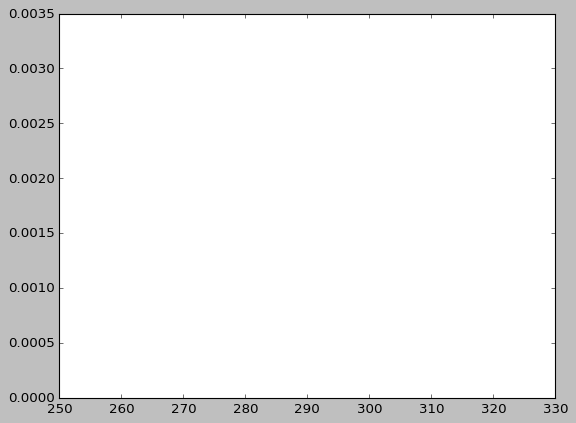

In [0]:
# MatPlotLib plotting scripts
plt.style.use('classic')

plt.axis([250, 330, 0, .0035])
plt.plot(L5_test_pdf[0][:,0], L5_test_pdf[0][:,1])
# plt.plot(L7_pdf[:,0], L7_pdf[:,1])
# plt.plot(L8_pdf[:,0], L8_pdf[:,1])

In [0]:
earthengine authenticate

SyntaxError: ignored

In [0]:
#!earthengine ls projects/ColoradoView/Landsat/ARD/7/LE07_CU_009011_20160519_20181210_C01_V01_stacked | Removed
#!earthengine rm projects/ColoradoView/Landsat/ARD/7/LE07_CU_009008_20070101_20190514_C01_V01_stacked | Removed
#!earthengine rm projects/ColoradoView/Landsat/ARD/7/LE07_CU_009008_20070117_20190514_C01_V01_stacked | Removed
#!earthengine rm projects/ColoradoView/Landsat/ARD/7/LE07_CU_009008_20070110_20181230_C01_V01_stacked | Removed
#!earthengine rm projects/ColoradoView/Landsat/ARD/7/LE07_CU_009008_20070202_20190514_C01_V01_stacked | Removed
#!earthengine rm projects/ColoradoView/Landsat/ARD/7/LE07_CU_009008_20070126_20181224_C01_V01_stacked | Removed
#!earthengine rm projects/ColoradoView/Landsat/ARD/7/LE07_CU_009008_20070218_20190514_C01_V01_stacked | Removed
#!earthengine rm projects/ColoradoView/Landsat/ARD/7/LE07_CU_009008_20070306_20190514_C01_V01_stacked | Removed
#!earthengine rm projects/ColoradoView/Landsat/ARD/7/LE07_CU_009008_20070313_20181223_C01_V01_stacked | Removed
LE07_CU_009008_20070227_20181230_C01_V01_stacked # Have not yet removed this one <---

In [0]:
!ls -a "/content/gdrive/My Drive/ARD_LST_CO/2007/7/Working/LE07_CU_009008_20070101_20190514_C01_V01_stacked*"

ls: cannot access '/content/gdrive/My Drive/ARD_LST_CO/2007/7/Working/LE07_CU_009008_20070101_20190514_C01_V01_stacked*': No such file or directory


Filter keys by month—**Skip for now** <BR>
*This is only necessary if you want to filter*

In [0]:
# # Function to produce lists of keys for each sensor
# def getList(dict): 
#     list = [] 
#     for key in dict.keys(): 
#         list.append(key)      
#     return list

# l5keys = getList(colHist5_cli)
# l7keys = getList(colHist7_cli)
# l8keys = getList(colHist8_cli)

# # Month to filter by
# filterMonth = '03'

# # Function to produce list of keys within the specified filterMonth
# # Can index the Month of the key by [19:21] index of string
# def filter_month(keys_list, clean_list):
#   for iKey in range(1,len(keys_list)):
#      # filter keys that are not from images, such as system keys
#     if keys_list[iKey][0] == 'L':
#       month = keys_list[iKey][19:21]
#       if month == filterMonth:
#         clean_list.append(keys_list[iKey])
#   return clean_list

# L5_filt_list = []
# l5_filt_keys = filter_month(l5keys, L5_filt_list)
# L7_filt_list = []
# l7_filt_keys = filter_month(l7keys, L7_filt_list)
# L8_filt_list = []
# l8_filt_keys = filter_month(l8keys, L8_filt_list)

# # Use dictionary comprehension to filter dictionary keys by the list of keys for the specified month
# colHist5_cli = {k: colHist5_cli[k] for k in l5_filt_keys if k in colHist5_cli}
# colHist7_cli = {k: colHist7_cli[k] for k in l7_filt_keys if k in colHist7_cli}
# colHist8_cli = {k: colHist8_cli[k] for k in l8_filt_keys if k in colHist8_cli}
# print(colHist5_cli.get('LT05_CU_009008_20040330_20190105_C01_V01_stacked_b1'))
# print(colHist5_cli.keys())
# print(type(colHist5_cli))
# print(len(colHist5_cli.keys()))
# print(len(colHist7_cli.keys()))
# print(len(colHist8_cli.keys()))

Filter by Landsat tile code—**Skip for now**

In [0]:
# # Tile locations: https://www.usgs.gov/media/images/conterminous-us-landsat-analysis-ready-data-ard-tiles
# # Need to filter for tiles in northeastern Colorado. Tile 013009 will work well.

# # Function to produce lists of keys for each sensor
# def getList(dict): 
#     list = [] 
#     for key in dict.keys(): 
#         list.append(key)      
#     return list

# l5keys = getList(colHist5_cli)
# l7keys = getList(colHist7_cli)
# l8keys = getList(colHist8_cli)

# # Month to filter by
# filterTile = '013009'

# # Function to produce list of keys within the specified filterMonth
# # Can index the Month of the key by [19:21] index of string
# def filter_tile(keys_list, clean_list):
#   for iKey in range(1,len(keys_list)):
#      # filter keys that are not from images, such as system keys
#     if keys_list[iKey][0] == 'L':
#       month = keys_list[iKey][8:14]
#       if month == filterTile:
#         clean_list.append(keys_list[iKey])
#   return clean_list

# L5_filt_list = []
# l5_filt_keys = filter_tile(l5keys, L5_filt_list)
# L7_filt_list = []
# l7_filt_keys = filter_tile(l7keys, L7_filt_list)
# L8_filt_list = []
# l8_filt_keys = filter_tile(l8keys, L8_filt_list)

# # Use dictionary comprehension to filter dictionary keys by the list of keys for the specified month
# colHist5_cli = {k: colHist5_cli[k] for k in l5_filt_keys if k in colHist5_cli}
# colHist7_cli = {k: colHist7_cli[k] for k in l7_filt_keys if k in colHist7_cli}
# colHist8_cli = {k: colHist8_cli[k] for k in l8_filt_keys if k in colHist8_cli}
# print(len(colHist5_cli.keys()))
# print(len(colHist7_cli.keys()))
# print(len(colHist8_cli.keys()))

Filter by season—**Skip for now**

In [0]:
# # Function to produce lists of keys for each sensor
# def getList(dict): 
#     list = [] 
#     for key in dict.keys(): 
#         list.append(key)      
#     return list

# l5keys = getList(colHist5_cli)
# l7keys = getList(colHist7_cli)
# l8keys = getList(colHist8_cli)

# # Month to filter by
# filterWinter = ['01', '02', '03', '04', '11', '12']
# filterSummer = ['05', '06', '07', '08', '09', '10']

# # Function to produce list of keys within the specified filterMonth
# # Can index the Month of the key by [19:21] index of string
# def filter_season(keys_list, clean_list):
#   for iKey in range(1,len(keys_list)):
#      # filter keys that are not from images, such as system keys
#     if keys_list[iKey][0] == 'L':
#       month = keys_list[iKey][19:21]
#       if month in filterWinter:
#         clean_list.append(keys_list[iKey])
#   return clean_list

# L5_filt_list = []
# l5_filt_keys = filter_season(l5keys, L5_filt_list)
# L7_filt_list = []
# l7_filt_keys = filter_season(l7keys, L7_filt_list)
# L8_filt_list = []
# l8_filt_keys = filter_season(l8keys, L8_filt_list)

# # Use dictionary comprehension to filter dictionary keys by the list of keys for the specified month
# colHist5_cli = {k: colHist5_cli[k] for k in l5_filt_keys if k in colHist5_cli}
# colHist7_cli = {k: colHist7_cli[k] for k in l7_filt_keys if k in colHist7_cli}
# colHist8_cli = {k: colHist8_cli[k] for k in l8_filt_keys if k in colHist8_cli}
# print(len(colHist5_cli.keys()))
# print(len(colHist7_cli.keys()))
# print(len(colHist8_cli.keys()))

In [0]:
!ls -l "/content/gdrive/My Drive/ARD_LST_CO/2007/7/Working/LE07_CU_009008_20070101_20190514_C01_V01_stacked.tif"

-rw------- 1 root root 6636338 Sep 24 16:04 '/content/gdrive/My Drive/ARD_LST_CO/2007/7/Working/LE07_CU_009008_20070101_20190514_C01_V01_stacked.tif'


In [0]:
!ls -lL "/content/gdrive/My Drive/ARD_LST_CO/2007/7/Working/LE07_CU_009008_20070117_20190514_C01_V01_stacked.tif"

-rw------- 1 root root 33768442 Sep 24 16:04 '/content/gdrive/My Drive/ARD_LST_CO/2007/7/Working/LE07_CU_009008_20070117_20190514_C01_V01_stacked.tif'
